In [38]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd


import keras
from keras.callbacks import ModelCheckpoint
from keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPool2D, Reshape
from keras.models import Sequential
from keras.utils import np_utils

from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv("fer2013.csv")
emotion_labels = {0: "Angry", 1: "Disgust", 2:"Fear", 3:"Happy", 4:"Sad", 5:"Surprise", 6:"Neutral"}
labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

In [3]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
df["Usage"].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [5]:
def process_data(main_df, use):
    subset_df = main_df[main_df["Usage"] == use]
    subset_df.drop(columns=['Usage'], inplace=True)
    subset_df['pixels'] = subset_df['pixels'].apply(lambda pixel_str: np.fromstring(pixel_str, sep=' '))
    x = np.vstack(subset_df['pixels'].values)
    x = x.reshape(-1, 48, 48, 1)
    y = subset_df['emotion'].values
    y = np_utils.to_categorical(y)
    
    return x, y

In [6]:
x_train, y_train = process_data(df, 'Training')
x_validation, y_validation = process_data(df, 'PublicTest')

/Users/ritvikareddy 1/Documents/GitHub/ml-project/venv/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/Users/ritvikareddy 1/Documents/GitHub/ml-project/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [7]:
x_validation.shape

(3589, 48, 48, 1)

In [12]:
model = Sequential()

model.add(Conv2D(64, 3, data_format="channels_last", kernel_initializer="he_normal", 
                 input_shape=(48, 48, 1), activation='relu'))
model.add(BatchNormalization())
# model.add(Activation("relu"))

model.add(Conv2D(64, 3, activation='relu'))
model.add(BatchNormalization())
# model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.6))

model.add(Conv2D(32, 3, activation='relu'))
model.add(BatchNormalization())
# model.add(Activation("relu"))

model.add(Conv2D(32, 3, activation='relu'))
model.add(BatchNormalization())
# model.add(Activation("relu"))

model.add(Conv2D(32, 3, activation='relu'))
model.add(BatchNormalization())
# model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.6))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
# model.add(Activation("relu"))
model.add(Dropout(0.6))

model.add(Dense(7, activation='softmax'))
# model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 46, 46, 64)        640       
_________________________________________________________________
batch_normalization_12 (Batc (None, 46, 46, 64)        256       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 44, 44, 64)        36928     
_________________________________________________________________
batch_normalization_13 (Batc (None, 44, 44, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 20, 20, 32)        18464     
__________

In [13]:
# save best weights
checkpoint = ModelCheckpoint(filepath='cnn_basic_2', verbose=1, save_best_only=True)

# num epochs
epochs = 20

# run model
model_history = model.fit(x_train, y_train, epochs=epochs,
                 shuffle=True,
                 batch_size=100, validation_data=(x_validation, y_validation),
                 callbacks=[checkpoint], verbose=2)

# save model to json
model_json = model.to_json()
with open("cnn2.json", "w") as json_file:
    json_file.write(model_json)

Train on 28709 samples, validate on 3589 samples
Epoch 1/20
 - 822s - loss: 2.2867 - acc: 0.2326 - val_loss: 1.7288 - val_acc: 0.3430

Epoch 00001: val_loss improved from inf to 1.72882, saving model to cnn_basic_2
Epoch 2/20
 - 876s - loss: 1.8152 - acc: 0.3280 - val_loss: 1.5551 - val_acc: 0.4076

Epoch 00002: val_loss improved from 1.72882 to 1.55515, saving model to cnn_basic_2
Epoch 3/20
 - 711s - loss: 1.6171 - acc: 0.3877 - val_loss: 1.4444 - val_acc: 0.4469

Epoch 00003: val_loss improved from 1.55515 to 1.44443, saving model to cnn_basic_2
Epoch 4/20
 - 756s - loss: 1.5024 - acc: 0.4237 - val_loss: 1.3749 - val_acc: 0.4723

Epoch 00004: val_loss improved from 1.44443 to 1.37489, saving model to cnn_basic_2
Epoch 5/20
 - 735s - loss: 1.4244 - acc: 0.4528 - val_loss: 1.3138 - val_acc: 0.4909

Epoch 00005: val_loss improved from 1.37489 to 1.31375, saving model to cnn_basic_2
Epoch 6/20
 - 728s - loss: 1.3769 - acc: 0.4701 - val_loss: 1.2855 - val_acc: 0.5057

Epoch 00006: val_lo

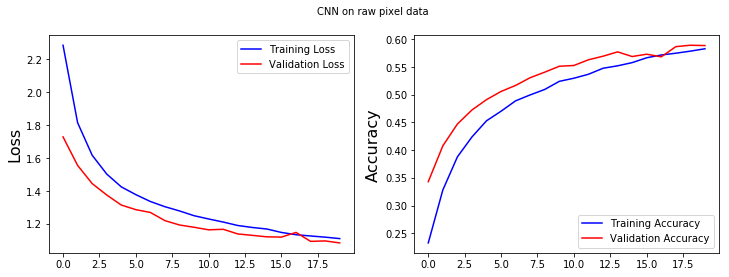

In [15]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.suptitle('CNN on raw pixel data', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(model_history.history['loss'], color='b', label='Training Loss')
plt.plot(model_history.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(model_history.history['acc'], color='b', label='Training Accuracy')
plt.plot(model_history.history['val_acc'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [16]:
x_test, y_test = process_data(df, "PrivateTest")
y_predicted_probs = model.predict(x_test, verbose=1)

/Users/ritvikareddy 1/Documents/GitHub/ml-project/venv/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/Users/ritvikareddy 1/Documents/GitHub/ml-project/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


3589/3589 [==============================] - 20s 5ms/step


In [17]:
score = model.evaluate(x_test, y_test, verbose=1)

3589/3589 [==============================] - 19s 5ms/step


In [18]:
print("Metrics: ", model.metrics_names)
print("Loss on test data", score[0])
print("Test Accuracy", score[1])

Metrics:  ['loss', 'acc']
Loss on test data 1.0537144673770766
Test Accuracy 0.6062970187013679


In [ ]:
# plot confusion matrix of predicted results for test data
# code borrowed from https://sunprinces.github.io/ML-Assignment3/p3.html


In [33]:
def convert_probs_to_labels(y_probs, labels):
    predicted_label = lambda x: labels[x.argmax()]
    return [predicted_label(each) for each in y_probs]

In [34]:
y_predicted_labels = convert_probs_to_labels(y_predicted_probs, labels)
y_actual_labels = convert_probs_to_labels(y_test, labels)

In [98]:
def test_for_single_image(file_name, model, labels):
    image_pixels = cv2.imread(file_name, 0)
#     print(len(image_pixels))
    image_input = image_pixels.reshape(-1, 48, 48, 1)
    predicted_emotion = model.predict(image_input, verbose=0)
#     print(predicted_emotion)
    print("This image is classified to be {} with {:.2f}% confidence".format(
        labels[predicted_emotion.argmax()],predicted_emotion.max()*100))
    

In [99]:
test_for_single_image('100th.jpg', model, labels)

This image is classified to be Surprise with 77.75% confidence


In [100]:
test_for_single_image('ashok.jpg', model, labels)

This image is classified to be Neutral with 48.55% confidence


In [101]:
test_for_single_image('ashok2.png', model, labels)

This image is classified to be Happy with 48.40% confidence


In [102]:
test_for_single_image('rose2.jpg', model, labels)

This image is classified to be Happy with 66.34% confidence


In [103]:
test_for_single_image('rose3.jpg', model, labels)

This image is classified to be Happy with 81.39% confidence


In [104]:
test_for_single_image('jose.png', model, labels)

This image is classified to be Happy with 97.59% confidence


In [105]:
test_for_single_image('rohit_happy.jpeg', model, labels)

This image is classified to be Neutral with 47.17% confidence
